# Step 1

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
import os

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [2]:
tickers = ["SPY", "TLT", "SHY", "GLD", "DBO"]
csv_filename = "stock_data.csv"

if os.path.isfile(csv_filename):
    df = pd.read_csv(csv_filename, index_col="Date", parse_dates=True)
else:
    df = yf.download(tickers, start="2010-01-01", end="2023-01-25")["Close"].dropna()
    df.to_csv(csv_filename)

print(df.tail(5))

              DBO         GLD        SHY         SPY         TLT
Date                                                            
2023-01-18  15.16  177.080002  81.870003  391.489990  108.629997
2023-01-19  15.40  179.889999  81.849998  388.640015  107.949997
2023-01-20  15.55  179.289993  81.779999  395.880005  106.199997
2023-01-23  15.60  179.630005  81.699997  400.630005  105.699997
2023-01-24  15.37  180.279999  81.730003  400.200012  107.220001


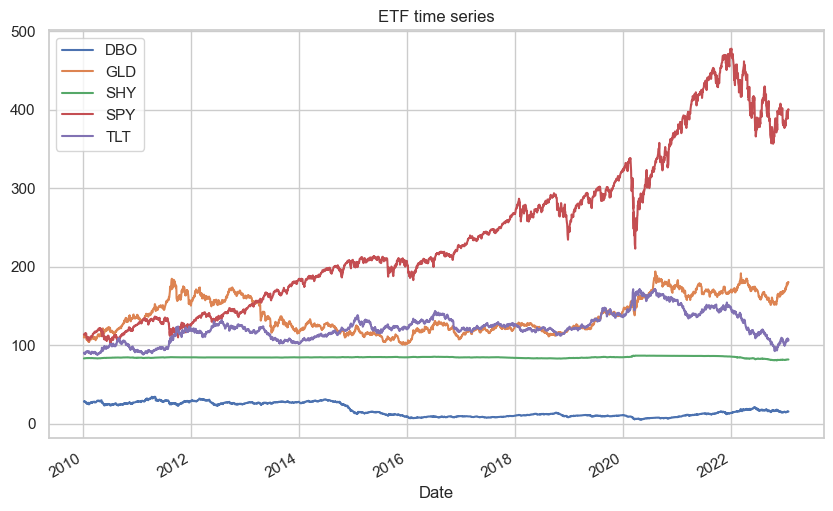

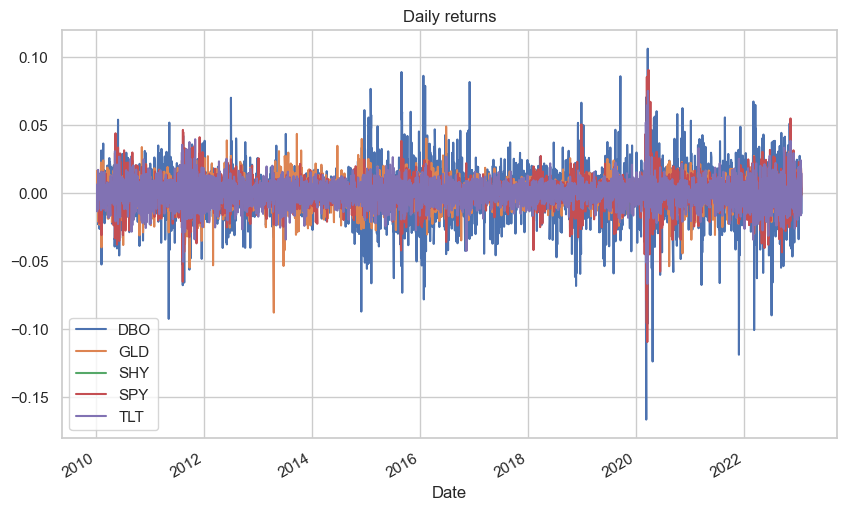

Summary statistics for daily returns:
               DBO          GLD          SHY          SPY          TLT
count  3286.000000  3286.000000  3286.000000  3286.000000  3286.000000
mean      0.000001     0.000200    -0.000005     0.000446     0.000100
std       0.019139     0.009878     0.000728     0.011131     0.009555
min      -0.166453    -0.087808    -0.005088    -0.109424    -0.066683
25%      -0.009470    -0.004846    -0.000353    -0.003831    -0.005614
50%       0.001105     0.000439     0.000000     0.000596     0.000494
75%       0.010433     0.005398     0.000353     0.005703     0.005710
max       0.106227     0.049038     0.005452     0.090603     0.075196


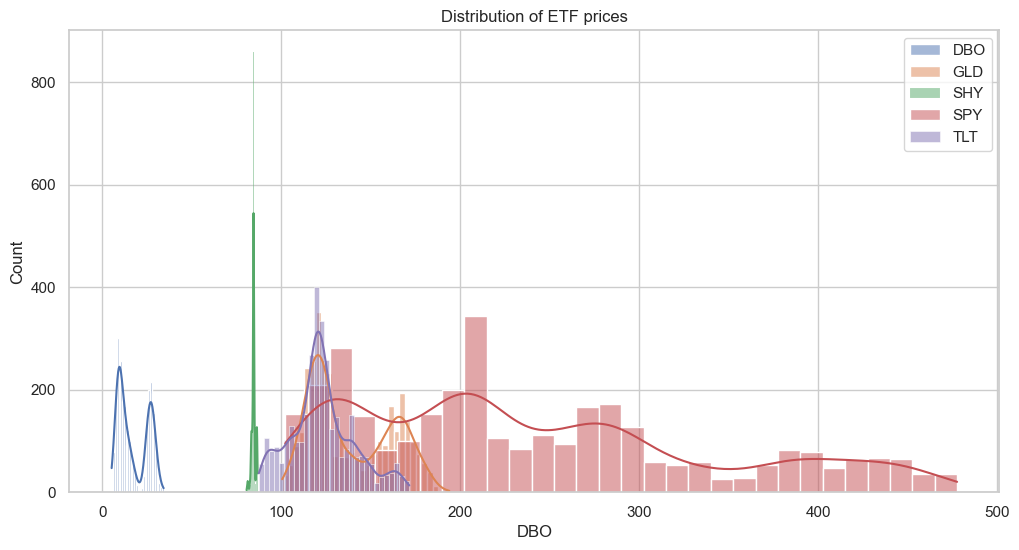

********** Stationarity test on Prices **********
ADF Test of DBO:
ADF Statistic: -1.3097186281644775
p-value: 0.6247143833144514
Critical Values: {'1%': -3.4323550398975238, '5%': -2.8624259071506413, '10%': -2.5672415871937777}
Is the time series stationary (ADF)? No


KPSS Test of DBO:
KPSS Statistic: 5.860972134794494
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary (KPSS)? No

----------------------------------------

ADF Test of GLD:
ADF Statistic: -1.5325140166789315
p-value: 0.5173702223361972
Critical Values: {'1%': -3.4323416055066382, '5%': -2.86241997328205, '10%': -2.5672384281310743}
Is the time series stationary (ADF)? No


KPSS Test of GLD:
KPSS Statistic: 2.107421587280617
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Is the time series stationary (KPSS)? No

----------------------------------------

ADF Test of SHY:
ADF Statistic: -0.8719131992135795
p-value: 0

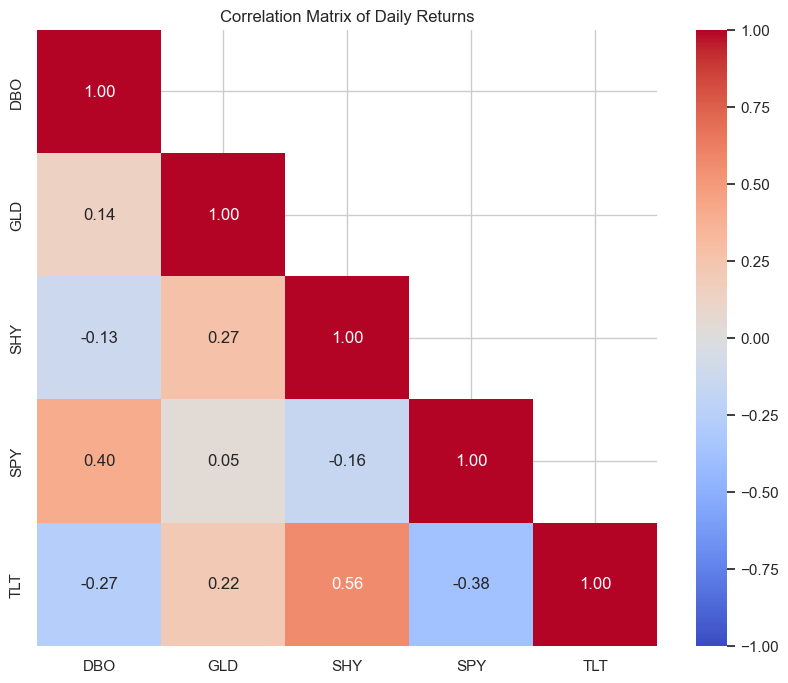

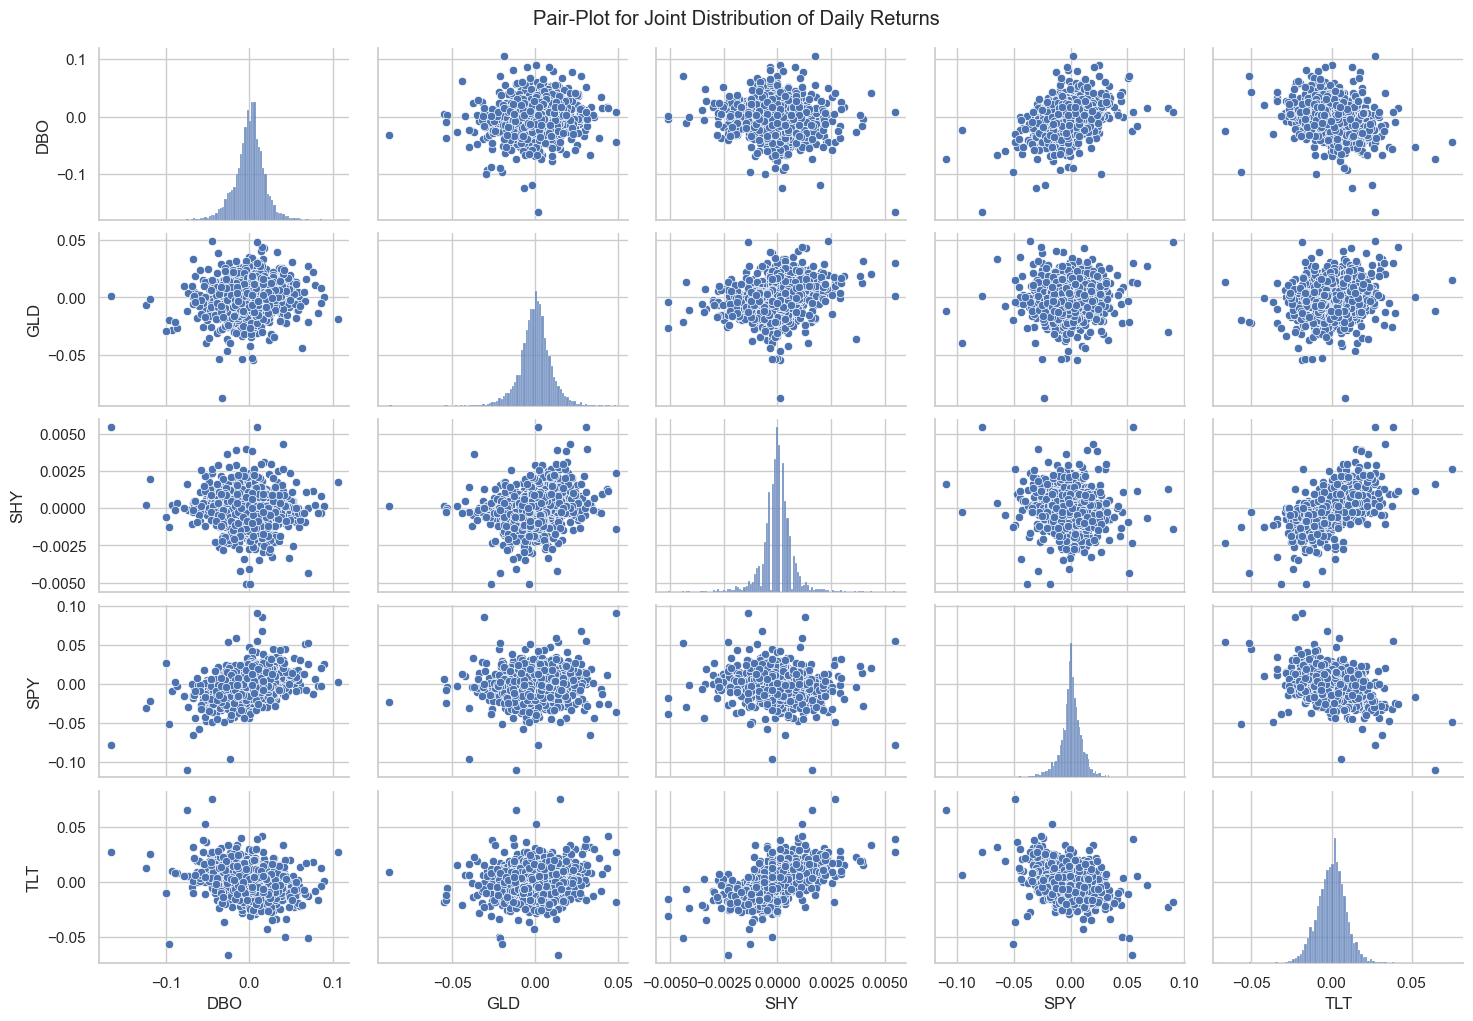

In [3]:
def perform_eda(df):
    '''
    Perform EDA on a dataframe containing time-series data.

    Parameters:
        - df (pd.DataFrame): DataFrame containing ETF time-series data

    Returns:
        None
    '''

    df.plot(figsize=(10, 6))
    plt.title("ETF time series")
    plt.show()

    returns = df.pct_change().dropna()
    returns.plot(figsize=(10, 6))
    plt.title("Daily returns")
    plt.show()

    summary_stats = returns.describe()
    print("Summary statistics for daily returns:")
    print(summary_stats)

    plt.figure(figsize=(12, 6))
    for ticker in df.columns:
        sns.histplot(df[ticker], kde=True, label=ticker, bins=30)
    plt.title("Distribution of ETF prices")
    plt.legend()
    plt.show()
    
    print("*" * 10, "Stationarity test on Prices", "*" * 10)
    for ticker in df.columns:
        result_adf = adfuller(df[ticker])
        print(f"ADF Test of {ticker}:")
        print("ADF Statistic:", result_adf[0])
        print("p-value:", result_adf[1])
        print("Critical Values:", result_adf[4])
        print("Is the time series stationary (ADF)?", "No" if result_adf[1] > 0.05 else "Yes")
        print("\n")

        result_kpss = kpss(df[ticker], regression='c', nlags="auto")
        print(f"KPSS Test of {ticker}:")
        print("KPSS Statistic:", result_kpss[0])
        print("p-value:", result_kpss[1])
        print("Critical Values:", result_kpss[3])
        print("Is the time series stationary (KPSS)?", "Yes" if result_kpss[1] > 0.05 else "No")
        print("\n" + "-"*40 + "\n")

    print("*" * 10, "Stationarity test on Returns", "*" * 10)
    for ticker in returns.columns:
        result_adf = adfuller(returns[ticker])
        print(f"ADF Test of {ticker}:")
        print("ADF Statistic:", result_adf[0])
        print("p-value:", result_adf[1])
        print("Critical Values:", result_adf[4])
        print("Is the time series stationary (ADF)?", "No" if result_adf[1] > 0.05 else "Yes")
        print("\n")

        result_kpss = kpss(returns[ticker], regression='c', nlags="auto")
        print(f"KPSS Test of {ticker}:")
        print("KPSS Statistic:", result_kpss[0])
        print("p-value:", result_kpss[1])
        print("Critical Values:", result_kpss[3])
        print("Is the time series stationary (KPSS)?", "Yes" if result_kpss[1] > 0.05 else "No")
        print("\n" + "-"*40 + "\n")

    correlation_matrix = returns.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, 
                mask=np.triu(correlation_matrix, 1), 
                vmin=-1,
                vmax=1,
                annot=True, 
                cmap='coolwarm', 
                fmt=".2f")
    plt.title('Correlation Matrix of Daily Returns')
    plt.show()

    sns.pairplot(returns, height=2, aspect=1.5)
    plt.suptitle('Pair-Plot for Joint Distribution of Daily Returns', y=1.02)
    plt.show()

perform_eda(df)

# Step 2


Training model for DBO...
Epoch 1/50
43/43 [==============================] - 6s 31ms/step - loss: 0.9061 - val_loss: 1.2713
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 0.8976 - val_loss: 1.2599
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9009 - val_loss: 1.2632
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 0.8913 - val_loss: 1.2634
Epoch 5/50
43/43 [==============================] - 1s 14ms/step - loss: 0.8960 - val_loss: 1.2653


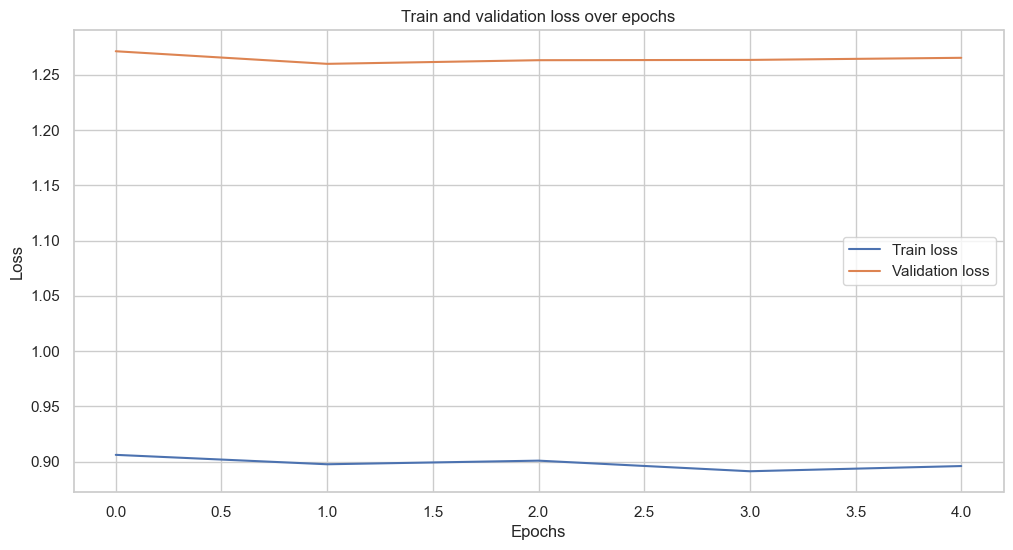

38/38 [==============================] - 0s 4ms/step


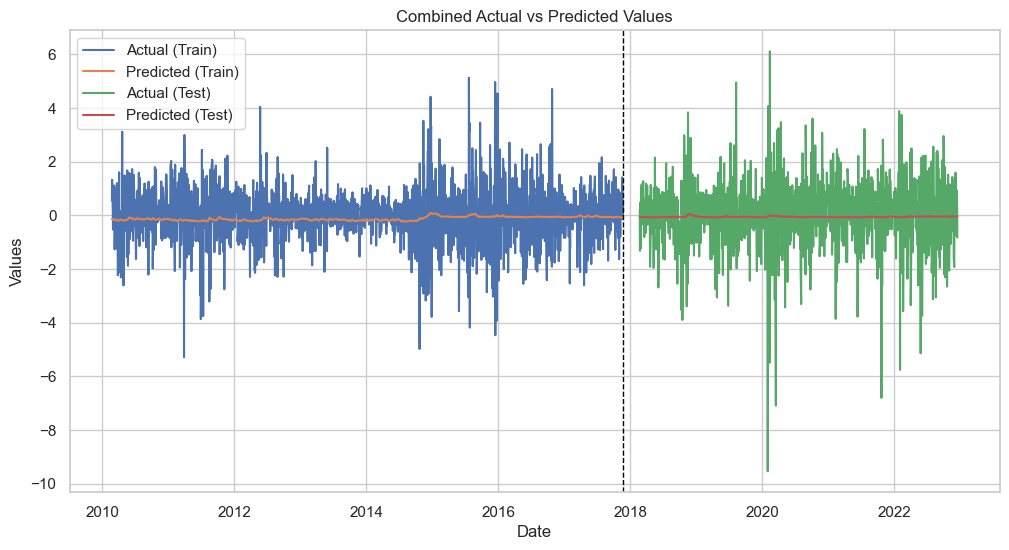

Mean squared error (Train): 1.005
Mean squared error (Test): 1.5867


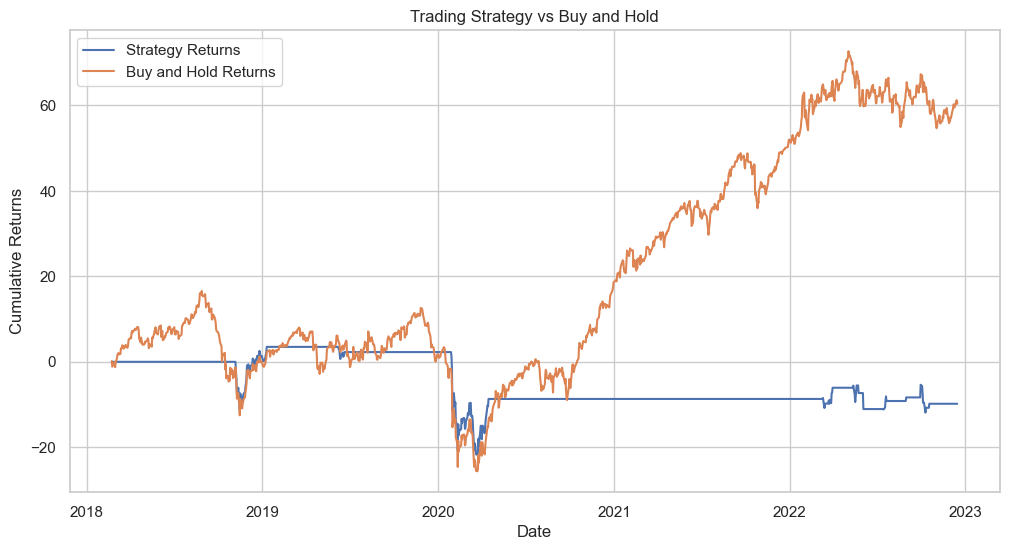

Strategy Percentage Return: -9.819999694824219%
Buy and Hold Percentage Return: 60.4%

Training model for GLD...
Epoch 1/50
43/43 [==============================] - 5s 31ms/step - loss: 1.1458 - val_loss: 0.6795
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1429 - val_loss: 0.6806
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1436 - val_loss: 0.6802
Epoch 4/50
43/43 [==============================] - 1s 12ms/step - loss: 1.1432 - val_loss: 0.6803


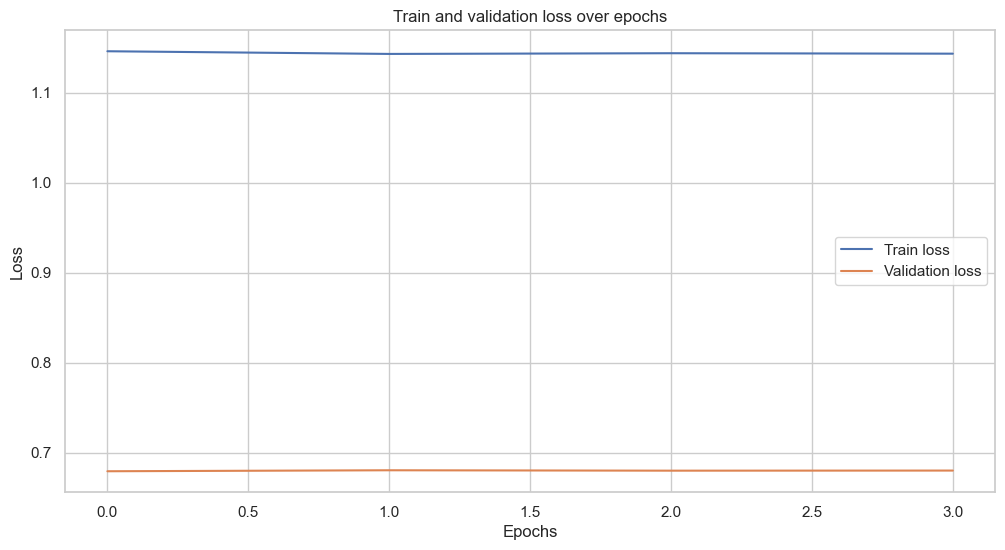

38/38 [==============================] - 0s 3ms/step


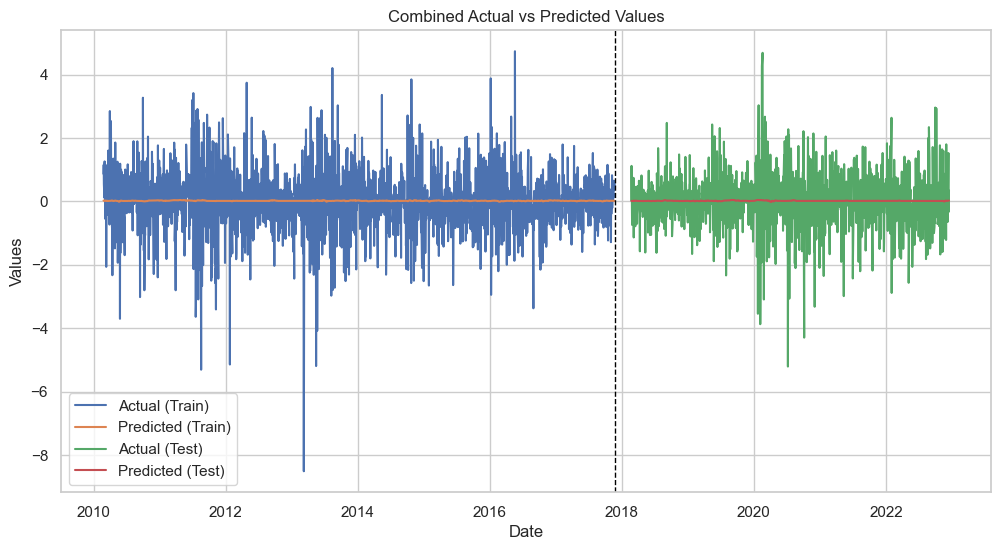

Mean squared error (Train): 0.999
Mean squared error (Test): 0.7831


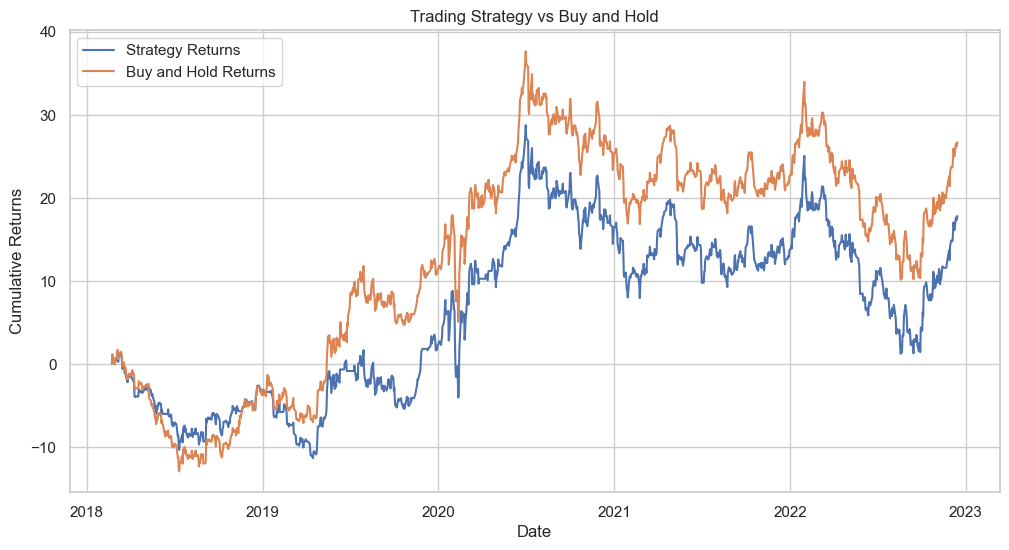

Strategy Percentage Return: 17.829999923706055%
Buy and Hold Percentage Return: 26.72%

Training model for SHY...
Epoch 1/50
43/43 [==============================] - 5s 31ms/step - loss: 0.9345 - val_loss: 1.1640
Epoch 2/50
43/43 [==============================] - 1s 12ms/step - loss: 0.9308 - val_loss: 1.1612
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9322 - val_loss: 1.1574
Epoch 4/50
43/43 [==============================] - 1s 12ms/step - loss: 0.9258 - val_loss: 1.1593
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9307 - val_loss: 1.1563
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9321 - val_loss: 1.1573
Epoch 7/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9347 - val_loss: 1.1583
Epoch 8/50
43/43 [==============================] - 1s 13ms/step - loss: 0.9302 - val_loss: 1.1591


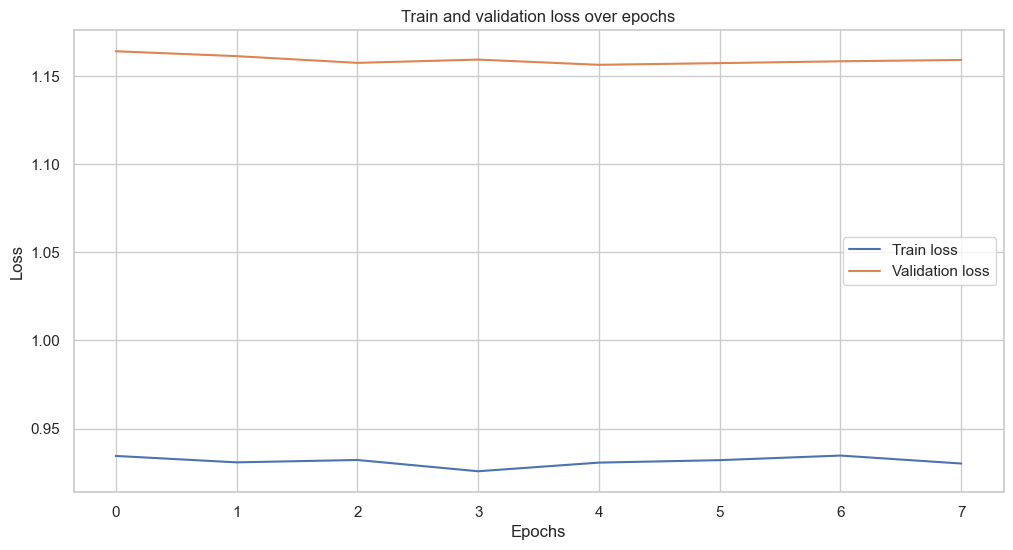

38/38 [==============================] - 0s 3ms/step


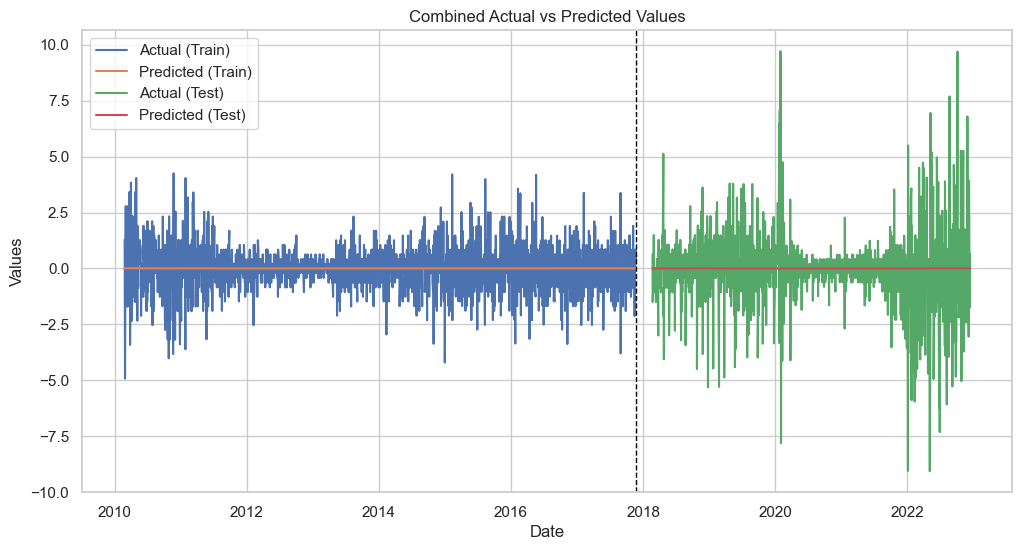

Mean squared error (Train): 0.9954
Mean squared error (Test): 2.8318


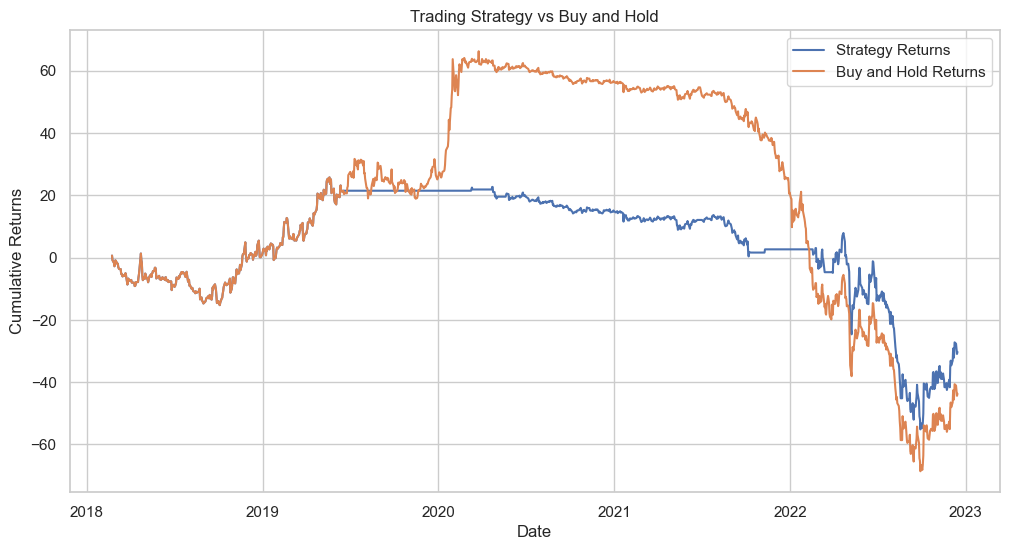

Strategy Percentage Return: -30.290000915527344%
Buy and Hold Percentage Return: -43.73%

Training model for SPY...
Epoch 1/50
43/43 [==============================] - 5s 31ms/step - loss: 1.1811 - val_loss: 0.6139
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1771 - val_loss: 0.6109
Epoch 3/50
43/43 [==============================] - 1s 12ms/step - loss: 1.1761 - val_loss: 0.6171
Epoch 4/50
43/43 [==============================] - 1s 12ms/step - loss: 1.1788 - val_loss: 0.6292
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1753 - val_loss: 0.6126


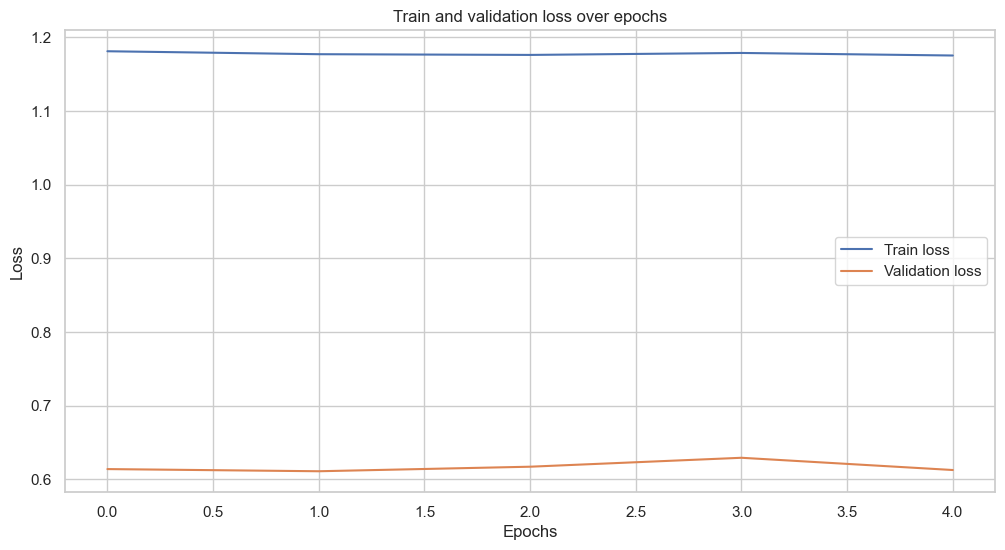

38/38 [==============================] - 0s 3ms/step


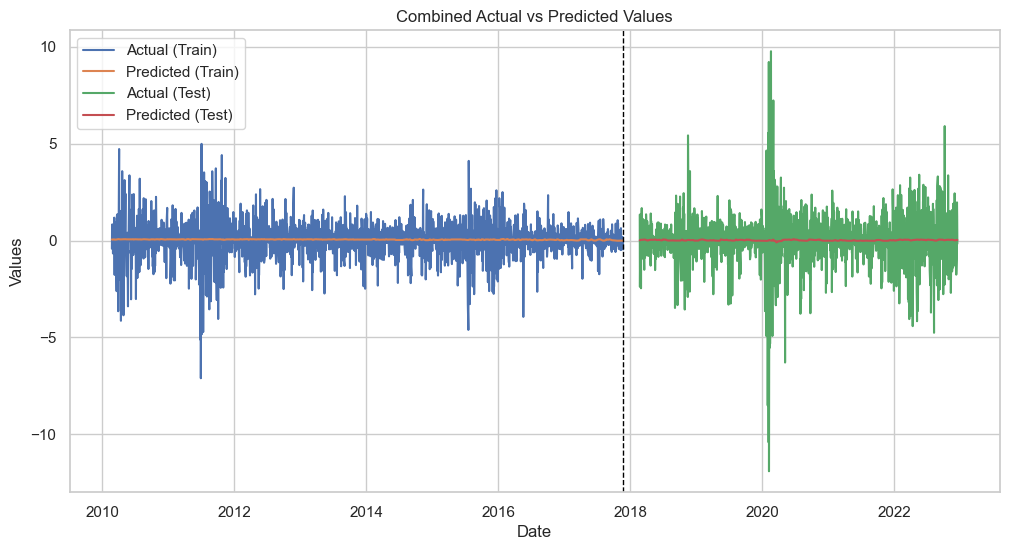

Mean squared error (Train): 1.0039
Mean squared error (Test): 2.1802


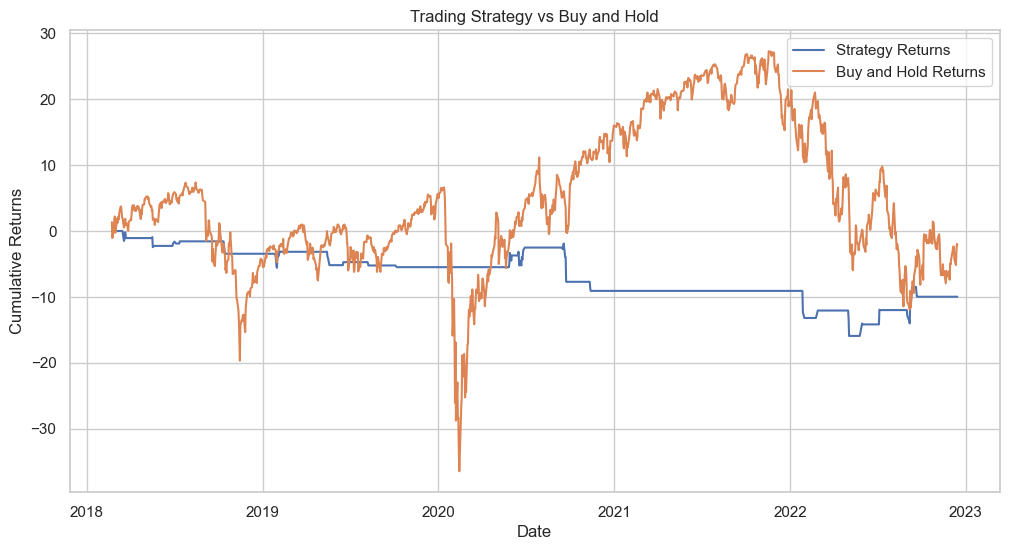

Strategy Percentage Return: -9.970000267028809%
Buy and Hold Percentage Return: -2.13%

Training model for TLT...
Epoch 1/50
43/43 [==============================] - 5s 31ms/step - loss: 1.1597 - val_loss: 0.6555
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1524 - val_loss: 0.6554
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1483 - val_loss: 0.6546
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1465 - val_loss: 0.6557
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1513 - val_loss: 0.6543
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1565 - val_loss: 0.6557
Epoch 7/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1528 - val_loss: 0.6559
Epoch 8/50
43/43 [==============================] - 1s 13ms/step - loss: 1.1521 - val_loss: 0.6551


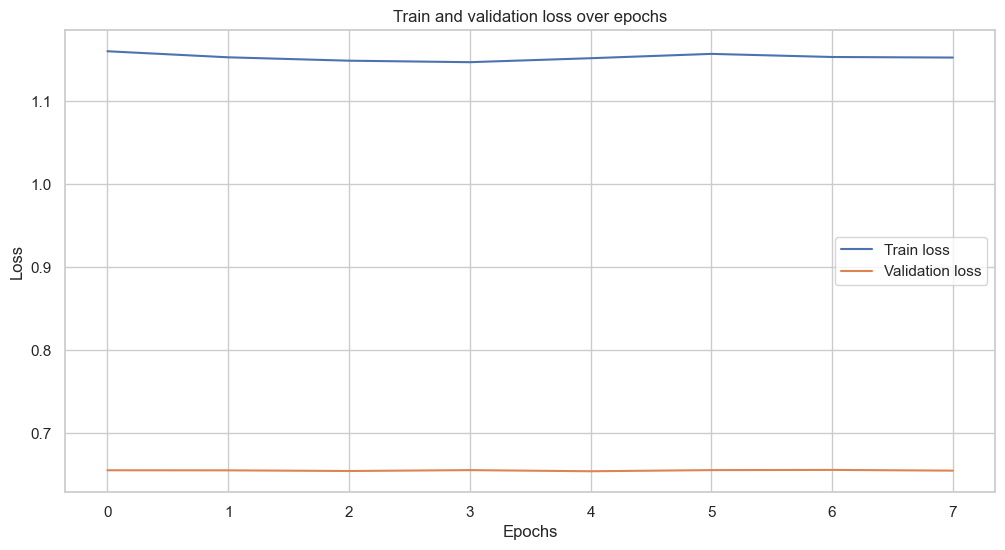

38/38 [==============================] - 0s 3ms/step


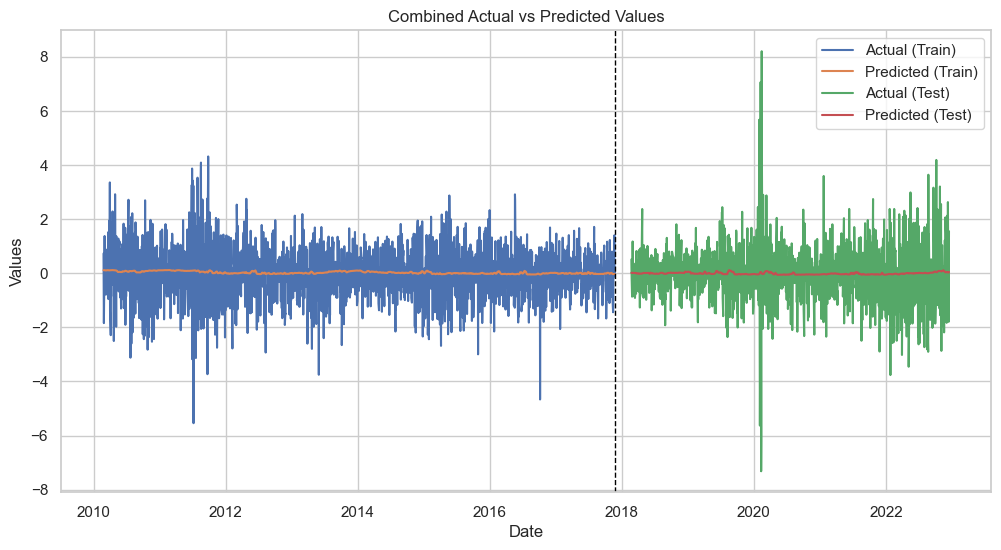

Mean squared error (Train): 0.9989
Mean squared error (Test): 1.29


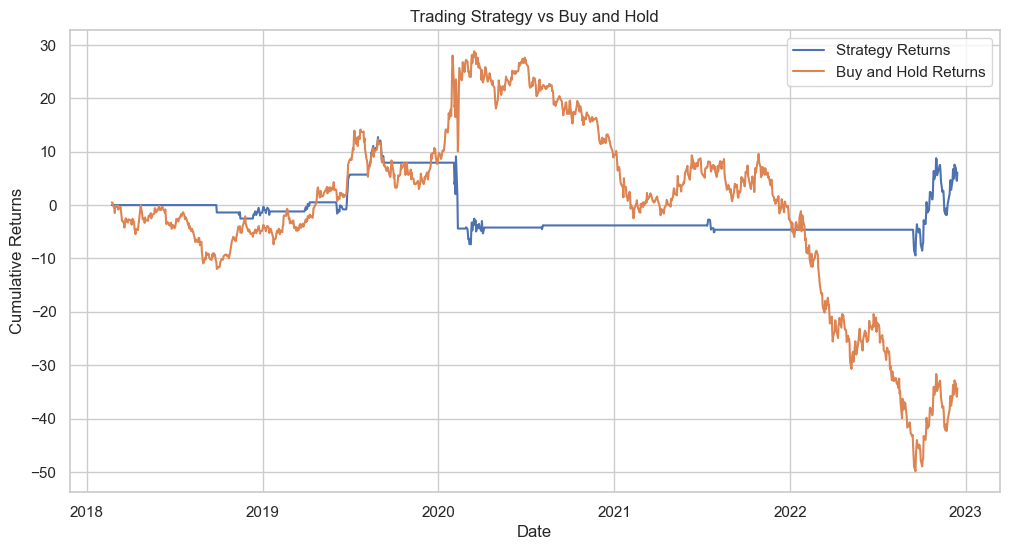

Strategy Percentage Return: 6.099999904632568%
Buy and Hold Percentage Return: -34.35%


In [4]:
# Set up GPU memory growth
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(42)

class LSTMPredictor:
    '''
    Class for training and evaluating LSTM models for financial time series prediction.
    '''
    def __init__(self, window_size=10, epochs=50, batch_size=32):
        '''
        Initialize the LSTMPredictor instance.

        Parameters:
            - window_size (int): Size of the input window form LSTM
            - epochs (int): Number of epochs for model training
            - batch_size (int): Batch size for training
        '''

        self.window_size = window_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.scaler = None

    def create_lstm_model(self):
        model = Sequential()
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(32, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(16, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error')

        return model

    def prepare_data(self, series, is_training=True):
        '''
        Prepare data for training and testing

        Parameters:
            - series (pd.Series): Input Series containing financial data
            - is_training (bool): Flag indicating whether the data is for training

        Returns:
            - features (ndarray): Array of input features
            - target (ndarry): Array of target values
            - dates (Index): Index corresponding to the target values
        '''
        data = pd.DataFrame(series)
        data.columns = ['close']
        data['return'] = data['close'].pct_change()

        # Apply technical analysis indicators using ta library
        data = (
            data
                .join(data.ta.bbands(), rsuffix='_bbands')
                .join(data.ta.ema(length=10), rsuffix='_ema_10')
                .join(data.ta.ema(length=25), rsuffix='_ema_25')
                .join(data.ta.sma(length=10), rsuffix='_sma_10')
                .join(data.ta.sma(length=15), rsuffix='_sma_15')
                .join(data.ta.sma(length=20), rsuffix='_sma_20')
                .join(data.ta.rsi(length=14), rsuffix='_rsi_14')
                .join(data.ta.rsi(length=25), rsuffix='_rsi_30')
        )

        data['target'] = data['return'].shift(-25)
        data.dropna(inplace=True)

        if is_training:
            self.scaler = StandardScaler()
            scaled_data = self.scaler.fit_transform(data)
        else:
            scaled_data = self.scaler.transform(data)

        features, targets = [], []
        for i in range(len(data) - self.window_size):
            features.append(scaled_data[i: i+self.window_size, :-1])
            targets.append(scaled_data[i+self.window_size, -1])

        features = np.array(features)
        targets = np.array(targets)

        return features, targets, data.index[-len(targets):]

    def evaluate_model(self, ticker, X_train, y_train, X_test, y_test, dates_train, dates_test):
        '''
        Evaluate the LSTM model on training and test data

        Parameters:
            - ticker (str): Ticker symbol of the financial instrument
            - X_train, y_train, X_test, y_test (ndarray): Training and testing data
            - dates_train, dates_test (Index): Index corresponding to training and test data
        '''
        y_train_pred = self.model.predict(X_train).flatten()
        y_test_pred = self.model.predict(X_test).flatten()

        train = np.concatenate([X_train[:, -1, :], y_train_pred.reshape(-1, 1)], axis=1)
        test = np.concatenate([X_test[:, -1, :], y_test_pred.reshape(-1, 1)], axis=1)

        y_train_pred_og = self.scaler.inverse_transform(train)[:,-1] * 100
        y_test_pred_og = self.scaler.inverse_transform(test)[:,-1] * 100

        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, y_train, label='Actual (Train)')
        plt.plot(dates_train, y_train_pred_og, label='Predicted (Train)')
        plt.axvline(x=dates_train[-1], color='black', linestyle='--', linewidth=1)
        plt.plot(dates_test, y_test, label='Actual (Test)')
        plt.plot(dates_test, y_test_pred_og, label='Predicted (Test)')

        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.title('Combined Actual vs Predicted Values')
        plt.legend()
        plt.show()

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)

        print(f"Mean squared error (Train): {np.round(mse_train, 4)}")
        print(f"Mean squared error (Test): {np.round(mse_test, 4)}")

        # Simple trading strategy based on predictions
        strategy_returns = np.zeros_like(y_test_pred)
        strategy_returns[y_test_pred > 0] = y_test[y_test_pred > 0]
        strategy_cumulative_returns = np.round(np.cumsum(strategy_returns), 4)

        # Buy and hold strategy
        buy_and_hold_returns = np.cumsum(y_test)

        # Plotting the trading strategy and buy-and-hold results
        plt.figure(figsize=(12, 6))
        plt.plot(dates_test, strategy_cumulative_returns, label='Strategy Returns')
        plt.plot(dates_test, buy_and_hold_returns, label='Buy and Hold Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Trading Strategy vs Buy and Hold')
        plt.legend()
        plt.show()

        # Calculate and print the percentage returns
        strategy_percentage_return = strategy_cumulative_returns[-1]
        buy_and_hold_percentage_return = buy_and_hold_returns[-1]

        print(f"Strategy Percentage Return: {np.round(strategy_percentage_return, 2)}%")
        print(f"Buy and Hold Percentage Return: {np.round(buy_and_hold_percentage_return, 2)}%")


    def train_and_evaluate(self, train_data, test_data):
        '''
        Train and evaluate LSTM models for each financial instrument

        Parameters:
            - train_data (DataFrame): Training data containing financial features
            - test_data (DataFrame): Test data containing financial features
        '''
        for ticker in train_data.columns:
            print(f'\nTraining model for {ticker}...')
            data_for_ticker = train_data[ticker]
            features, target, dates_train = self.prepare_data(data_for_ticker, is_training=True)

            self.model = self.create_lstm_model()
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            history = self.model.fit(
                features, target, epochs=self.epochs,
                callbacks=[early_stopping], shuffle=False,
                validation_split=0.3, verbose=1
            )

            plt.figure(figsize=(12, 6))
            plt.plot(history.history['loss'], label='Train loss')
            plt.plot(history.history['val_loss'], label='Validation loss')
            plt.title('Train and validation loss over epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            test_data_for_ticker = test_data[ticker]
            X_test, y_test, dates_test = self.prepare_data(test_data_for_ticker, is_training=False)

            self.evaluate_model(ticker, features, target, X_test, y_test, dates_train, dates_test)

train_data = df.loc[:"2017-12-31"]
test_data = df.loc["2018-01-01":]

lstm_predictor = LSTMPredictor()
lstm_predictor.train_and_evaluate(train_data, test_data)

# Step 3

Epoch 1/50
43/43 [==============================] - 5s 36ms/step - loss: 1.0632 - val_loss: 0.8742
Epoch 2/50
43/43 [==============================] - 1s 16ms/step - loss: 1.0546 - val_loss: 0.8731
Epoch 3/50
43/43 [==============================] - 1s 17ms/step - loss: 1.0560 - val_loss: 0.8719
Epoch 4/50
43/43 [==============================] - 1s 17ms/step - loss: 1.0547 - val_loss: 0.8745
Epoch 5/50
43/43 [==============================] - 1s 17ms/step - loss: 1.0515 - val_loss: 0.8723
Epoch 6/50
43/43 [==============================] - 1s 17ms/step - loss: 1.0535 - val_loss: 0.8738


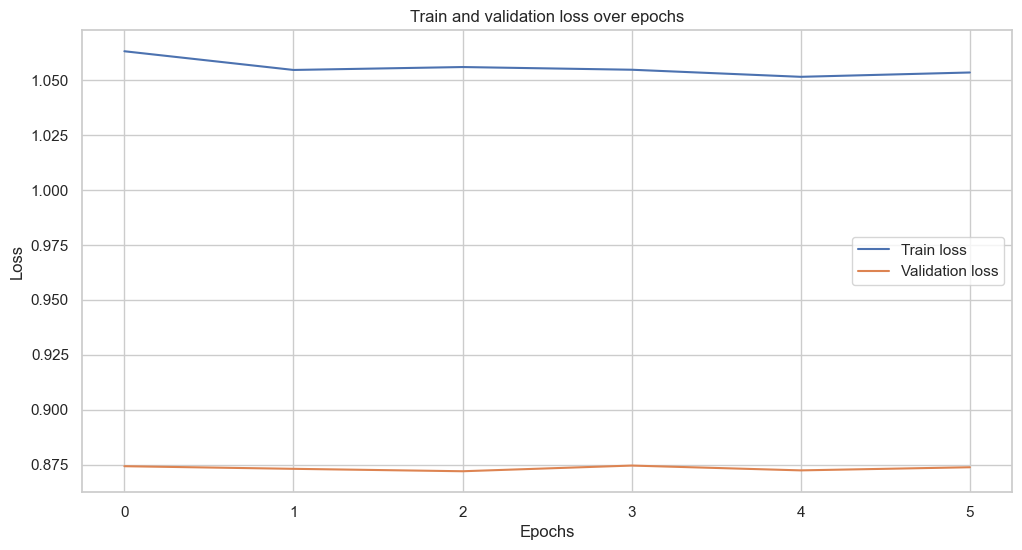

38/38 [==============================] - 0s 4ms/step


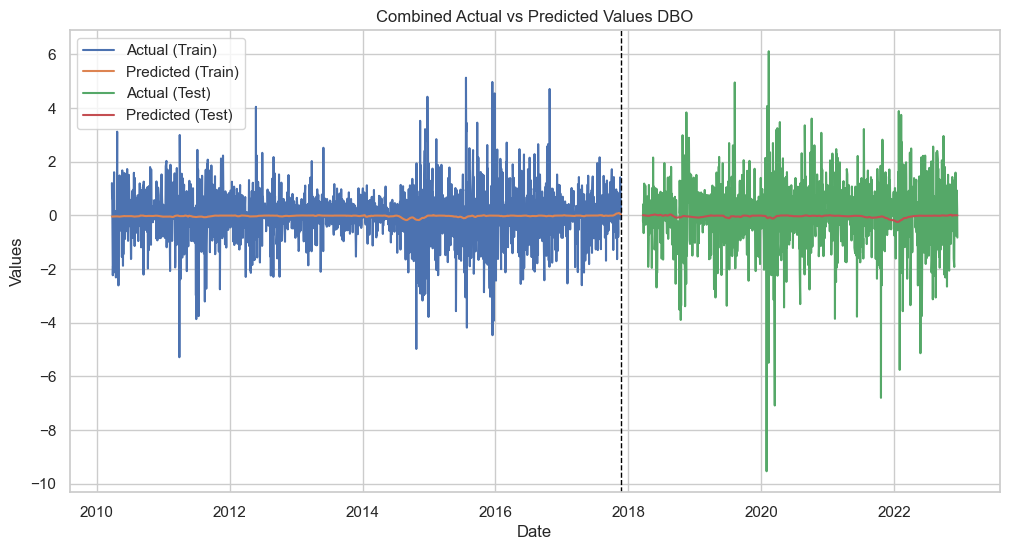

Mean squared error (Train): 1.0024
Mean squared error (Test): 1.6116


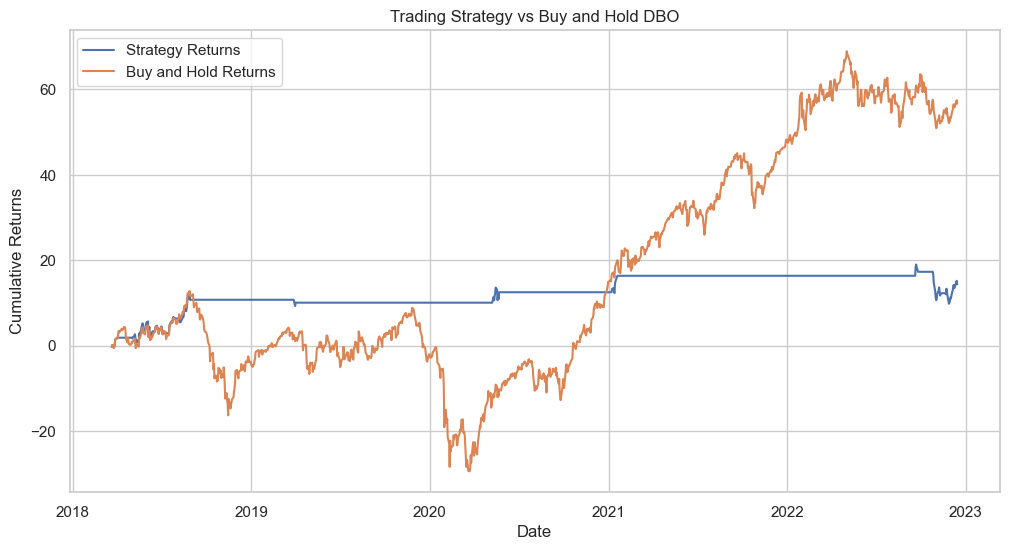

Strategy Percentage Return: 14.38%
Buy and Hold Percentage Return: 56.65%


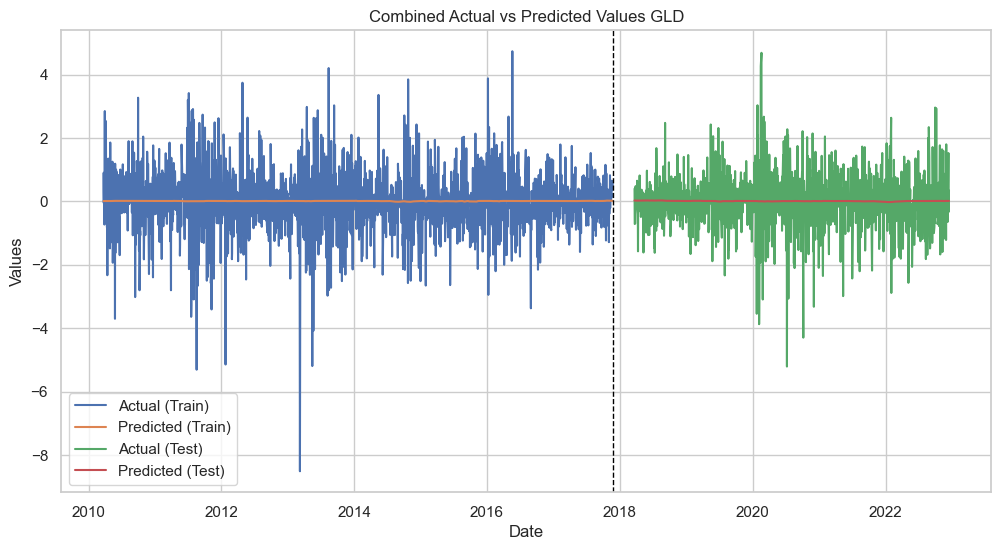

Mean squared error (Train): 1.002
Mean squared error (Test): 0.7908


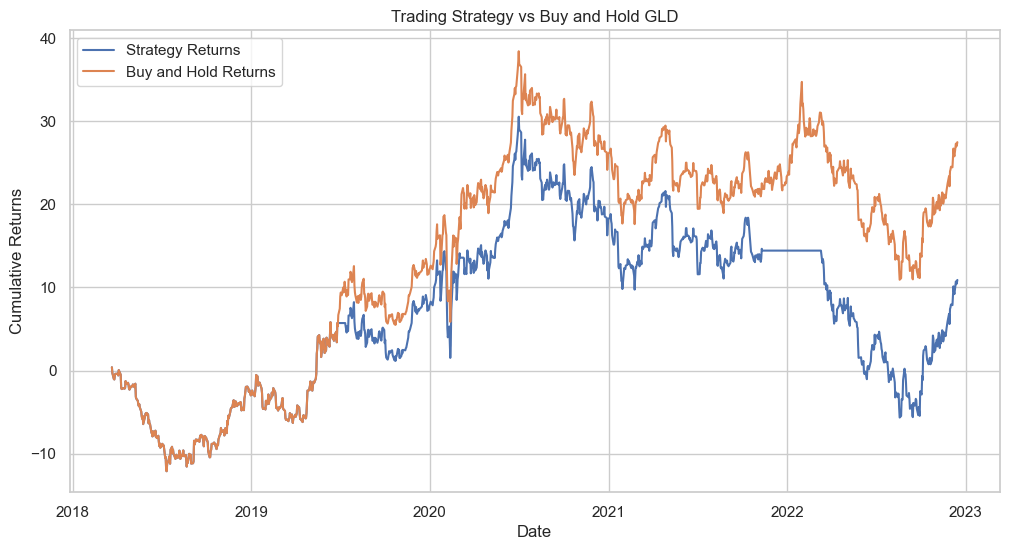

Strategy Percentage Return: 10.91%
Buy and Hold Percentage Return: 27.49%


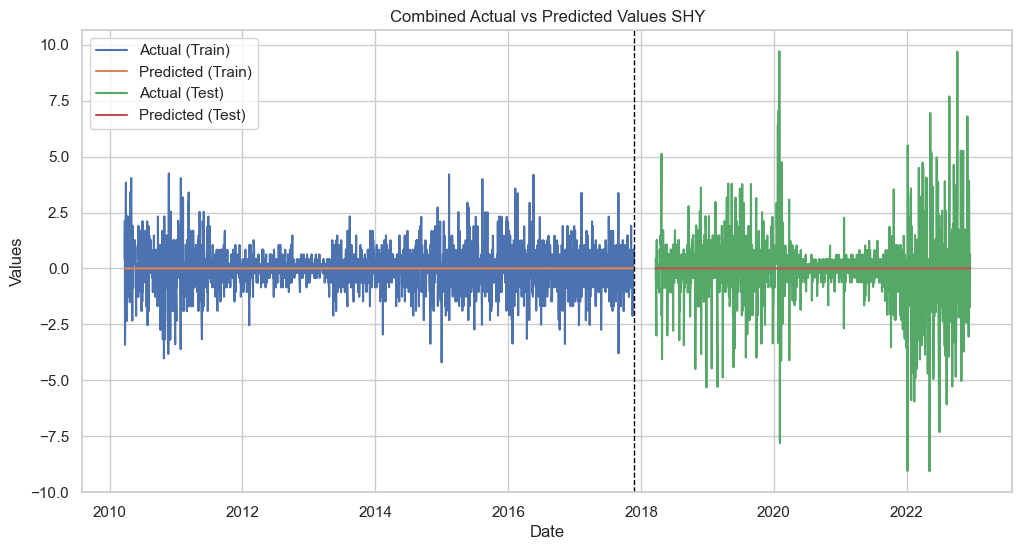

Mean squared error (Train): 0.9729
Mean squared error (Test): 2.8631


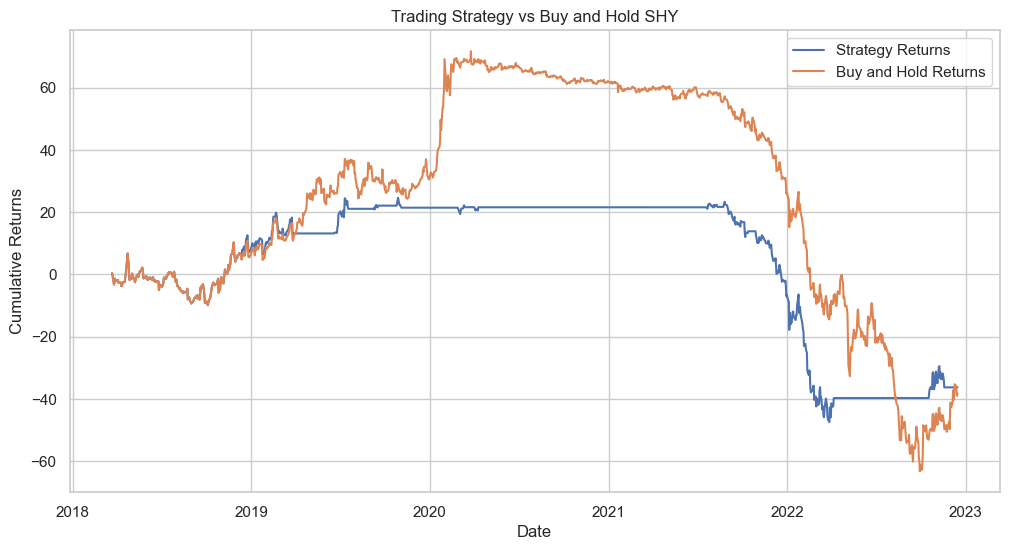

Strategy Percentage Return: -36.24%
Buy and Hold Percentage Return: -38.3%


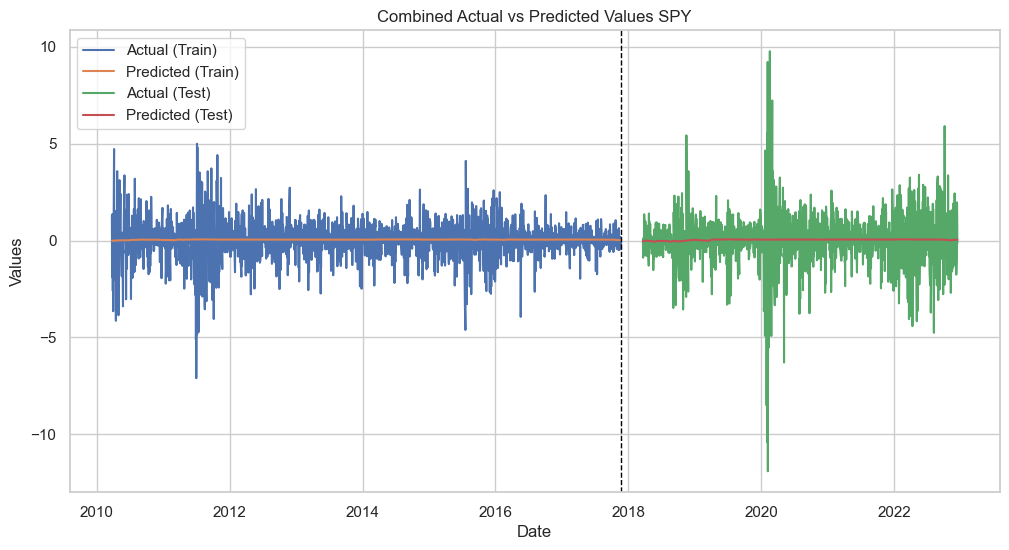

Mean squared error (Train): 1.0077
Mean squared error (Test): 2.1923


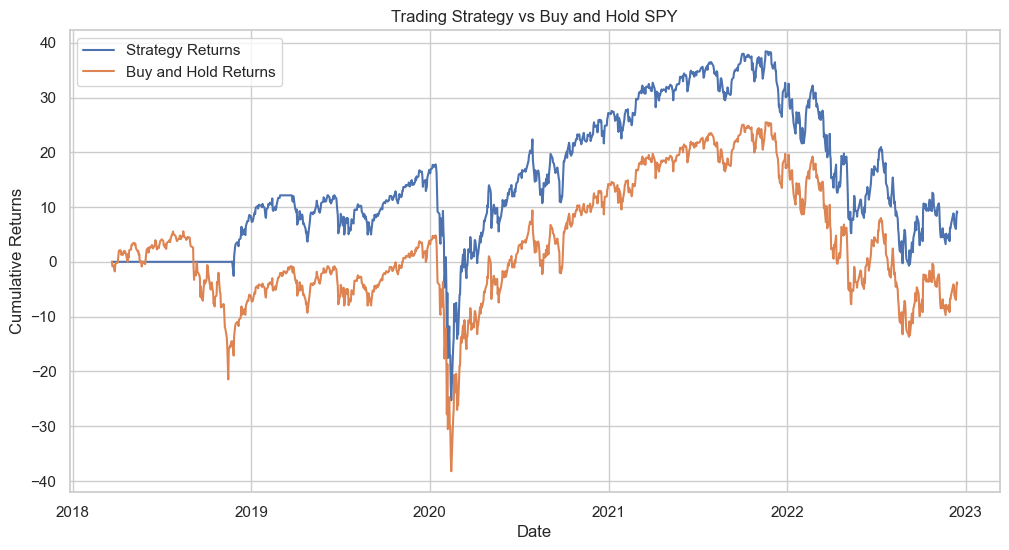

Strategy Percentage Return: 9.05%
Buy and Hold Percentage Return: -3.92%


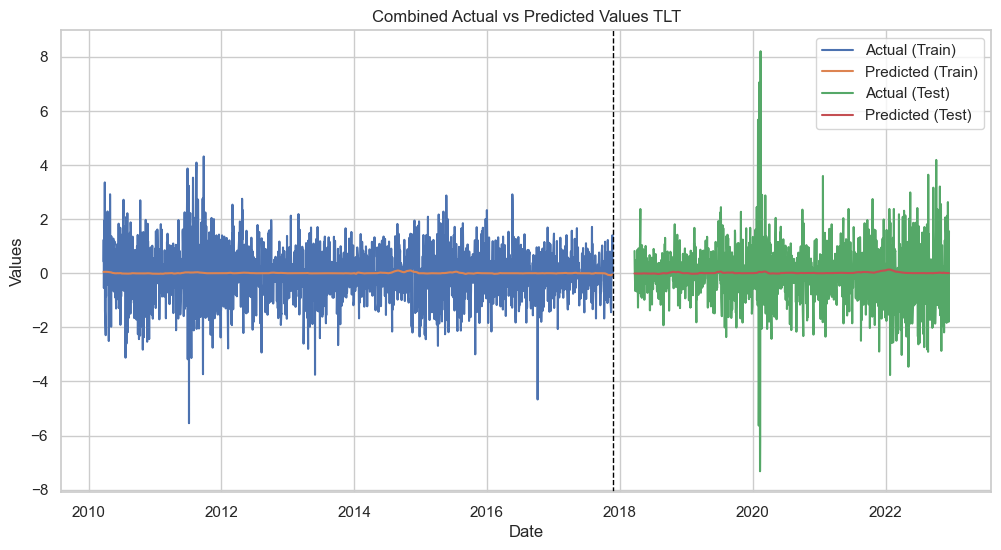

Mean squared error (Train): 1.004
Mean squared error (Test): 1.3087


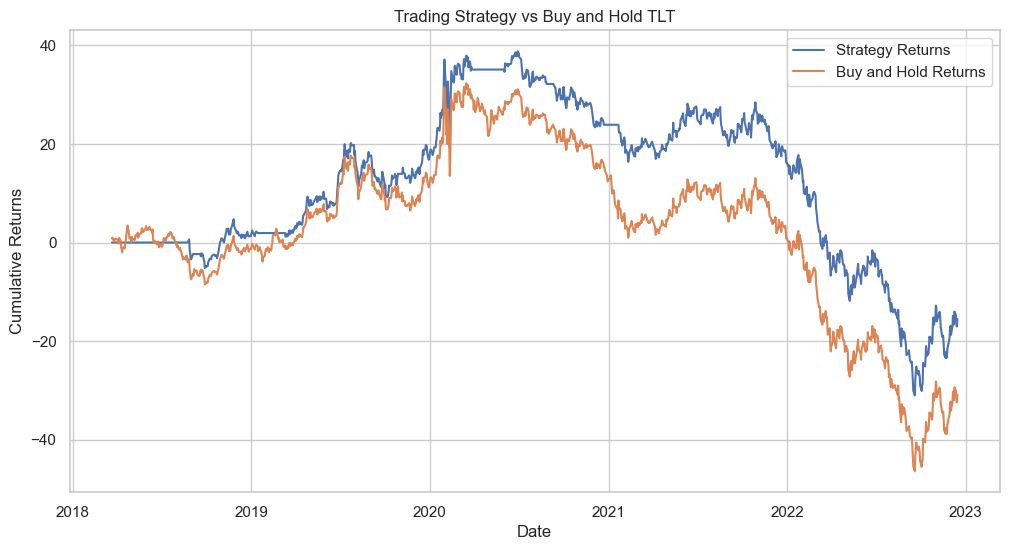

Strategy Percentage Return: -15.49%
Buy and Hold Percentage Return: -30.87%


In [5]:
# Set up GPU memory growth
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(42)

class LSTMMultiOutPredictor:
    '''
    Class for training and evaluating LSTM models for financial time series prediction.
    '''
    def __init__(self, window_size=30, epochs=50, batch_size=32):
        '''
        Initialize the LSTMPredictor instance.

        Parameters:
            - window_size (int): Size of the input window from LSTM
            - epochs (int): Number of epochs for model training
            - batch_size (int): Batch size for training
        '''

        self.window_size = window_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.scaler = None
        self.tickers = None

    def create_lstm_model(self):
        model = Sequential()
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(32, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(16, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(5))
        
        model.compile(loss='mean_squared_error')

        return model

    def prepare_data(self, df, is_training=True):
        '''
        Prepare data for training and testing

        Parameters:
            - df (DataFrame): Input DataFrame containing financial data
            - is_training (bool): Flag indicating whether the data is for training

        Returns:
            - features (ndarray): Array of input features
            - targets (ndarray): Array of target values
            - dates (Index): Index corresponding to the target values
        '''
        self.tickers = df.columns
        data = pd.DataFrame()

        for ticker in df.columns:
            temp_df = df[[ticker]].rename(columns={ticker: 'Close'})
            
            data_ta = (temp_df
                    .join(temp_df.ta.bbands(), rsuffix='_bbands')
                    .join(temp_df.ta.ema(length=10), rsuffix='_ema_10')
                    .join(temp_df.ta.ema(length=25), rsuffix='_ema_25')
                    .join(temp_df.ta.sma(length=10), rsuffix='_sma_10')
                    .join(temp_df.ta.sma(length=15), rsuffix='_sma_15')
                    .join(temp_df.ta.sma(length=20), rsuffix='_sma_20')
                    .join(temp_df.ta.rsi(length=14), rsuffix='_rsi_14')
                    .join(temp_df.ta.rsi(length=25), rsuffix='_rsi_25')
                   )

            data_ta.columns = [f'{col}_{ticker}' for col in data_ta.columns]
        
            data = pd.concat([data, data_ta], axis=1)

        for ticker in df.columns:
            data[f'target_{ticker}'] = data[f'Close_{ticker}'].pct_change().shift(-25)
        
        data.dropna(inplace=True)

        if is_training:
            self.scaler = StandardScaler()
            scaled_data = self.scaler.fit_transform(data)
        else:
            scaled_data = self.scaler.transform(data)

        features, targets = [], []
        for i in range(len(data) - self.window_size):
            features.append(scaled_data[i: i+self.window_size, :-5])
            targets.append(scaled_data[i+self.window_size, -5:])

        features = np.array(features)
        targets = np.array(targets)

        return features, targets, data.index[-len(targets):]

    def evaluate_model(self, X_train, y_train, X_test, y_test, dates_train, dates_test):
        '''
        Evaluate the LSTM model on training and test data

        Parameters:
            - X_train, y_train, X_test, y_test (ndarray): Training and testing data
            - dates_train, dates_test (Index): Index corresponding to training and test data
        '''
        y_train_pred = self.model.predict(X_train)
        y_test_pred = self.model.predict(X_test)

        train = np.concatenate([X_train[:, -1, :].reshape(len(X_train), -1), y_train_pred], axis=1)
        test = np.concatenate([X_test[:, -1, :].reshape(len(X_test), -1), y_test_pred], axis=1)

        y_train_pred_og = self.scaler.inverse_transform(train)[:,-5:] * 100
        y_test_pred_og = self.scaler.inverse_transform(test)[:,-5:] * 100

        for i, col in enumerate(self.tickers):
            plt.figure(figsize=(12, 6))
            plt.plot(dates_train, y_train[:, i], label=f'Actual (Train)')
            plt.plot(dates_train, y_train_pred_og[:, i], label=f'Predicted (Train)')
            plt.axvline(x=dates_train[-1], color='black', linestyle='--', linewidth=1)
            plt.plot(dates_test, y_test[:, i], label=f'Actual (Test)')
            plt.plot(dates_test, y_test_pred_og[:, i], label=f'Predicted (Test)')
    
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.title(f'Combined Actual vs Predicted Values {col}')
            plt.legend()
            plt.show()
    
            mse_train = mean_squared_error(y_train[:, i], y_train_pred_og[:, i])
            mse_test = mean_squared_error(y_test[:, i], y_test_pred_og[:, i])
    
            print(f"Mean squared error (Train): {np.round(mse_train, 4)}")
            print(f"Mean squared error (Test): {np.round(mse_test, 4)}")
    
            # Simple trading strategy based on predictions
            strategy_returns = np.zeros_like(y_test_pred_og[:, i])
            strategy_returns[y_test_pred_og[:, i] > 0] = y_test[:, i][y_test_pred_og[:, i] > 0]
            strategy_cumulative_returns = np.cumsum(strategy_returns)
    
            # Buy and hold strategy
            buy_and_hold_returns = np.cumsum(y_test[:, i])
    
            # Plotting the trading strategy and buy-and-hold results
            plt.figure(figsize=(12, 6))
            plt.plot(dates_test, strategy_cumulative_returns, label='Strategy Returns')
            plt.plot(dates_test, buy_and_hold_returns, label='Buy and Hold Returns')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Returns')
            plt.title(f'Trading Strategy vs Buy and Hold {col}')
            plt.legend()
            plt.show()
    
            # Calculate and print the percentage returns
            strategy_percentage_return = strategy_cumulative_returns[-1]
            buy_and_hold_percentage_return = buy_and_hold_returns[-1]
            print(f"Strategy Percentage Return: {np.round(strategy_percentage_return, 2)}%")
            print(f"Buy and Hold Percentage Return: {np.round(buy_and_hold_percentage_return, 2)}%")

    def train_and_evaluate(self, train_data, test_data):
        '''
        Train and evaluate LSTM models for each financial instrument

        Parameters:
            - train_data (DataFrame): Training data containing financial features
            - test_data (DataFrame): Test data containing financial features
        '''
        features, target, dates_train = self.prepare_data(train_data, is_training=True)

        self.model = self.create_lstm_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = self.model.fit(
            features, target, epochs=self.epochs,
            callbacks=[early_stopping], shuffle=False,
            validation_split=0.3, verbose=1
        )

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Train loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.title('Train and validation loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        X_test, y_test, dates_test = self.prepare_data(test_data, is_training=False)

        self.evaluate_model(features, target, X_test, y_test, dates_train, dates_test)

train_data = df.loc[:"2017-12-31"]
test_data = df.loc["2018-01-01":]

lstm_predictor = LSTMMultiOutPredictor()
lstm_predictor.train_and_evaluate(train_data, test_data)